In [1]:
from orion.data import load_signal, load_anomalies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

In [3]:
signal = 'S-1-train'

In [4]:
# load signal

In [5]:
df = load_signal(signal)

In [6]:
# load ground truth anomalies

In [7]:
known_anomalies = load_anomalies('S-1')

In [8]:
print(df.head())

    timestamp     value
0  1222819200 -0.366359
1  1222840800 -0.394108
2  1222862400  0.403625
3  1222884000 -0.362759
4  1222905600 -0.370746


In [9]:
print(known_anomalies)

        start         end
0  1398168000  1407823200


In [10]:
df['timestamp'][0]-df['timestamp'][1]

-21600

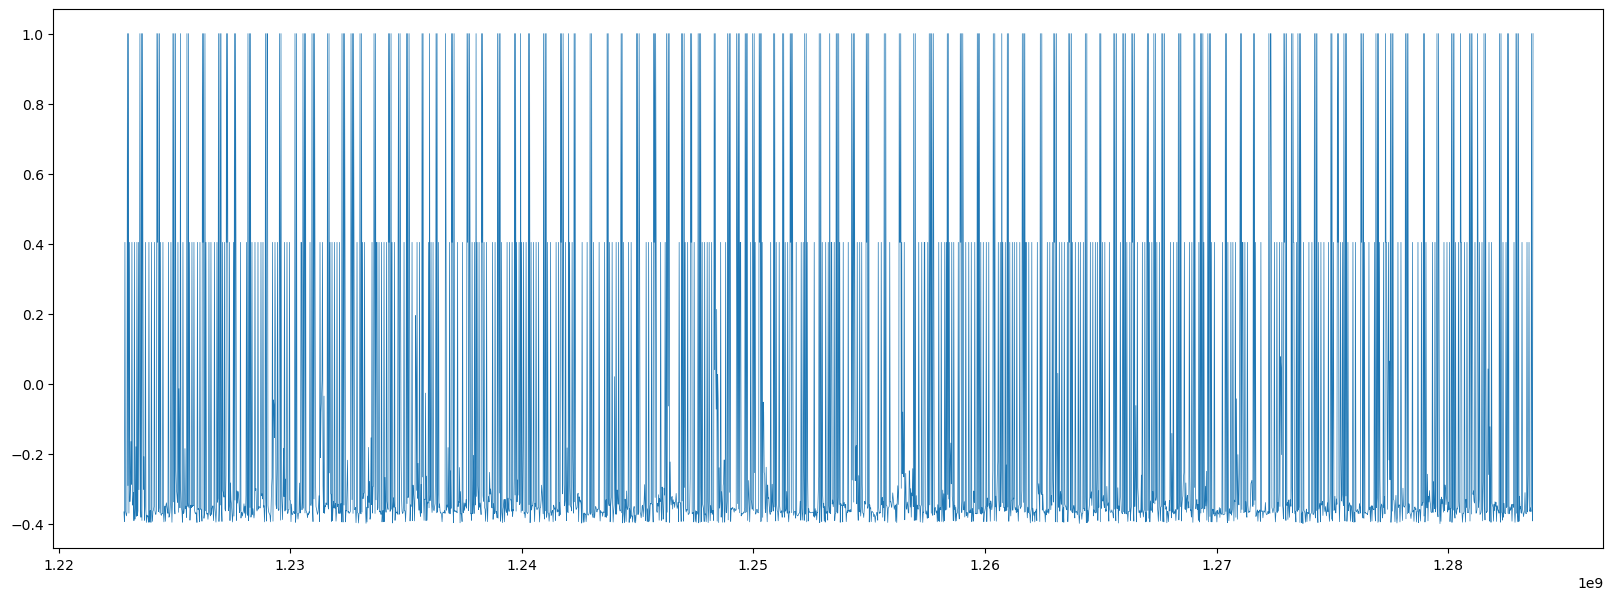

In [11]:
fig, ax = plt.subplots(figsize=(20,7))

ax.plot(df['timestamp'], df['value'], linewidth=0.5)

plt.show()

In [12]:
def time_segments_aggregate(X, interval, time_column, method=['mean']):
    """Aggregate values over given time span.
    Args:
        X (ndarray or pandas.DataFrame):
            N-dimensional sequence of values.
        interval (int):
            Integer denoting time span to compute aggregation of.
        time_column (int):
            Column of X that contains time values.
        method (str or list):
            Optional. String describing aggregation method or list of strings describing multiple
            aggregation methods. If not given, `mean` is used.
    Returns:
        ndarray, ndarray:
            * Sequence of aggregated values, one column for each aggregation method.
            * Sequence of index values (first index of each aggregated segment).
    """
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    X = X.sort_values(time_column).set_index(time_column)

    if isinstance(method, str):
        method = [method]

    start_ts = X.index.values[0]
    max_ts = X.index.values[-1]

    values = list()
    index = list()
    while start_ts <= max_ts:
        end_ts = start_ts + interval
        subset = X.loc[start_ts:end_ts - 1]
        aggregated = [
            getattr(subset, agg)(skipna=True).values
            for agg in method
        ]
        values.append(np.concatenate(aggregated))
        index.append(start_ts)
        start_ts = end_ts

    return np.asarray(values), np.asarray(index)


In [13]:
X, index = time_segments_aggregate(df, interval=21600, time_column='timestamp')

In [14]:
imp = SimpleImputer()
X = imp.fit_transform(X)

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

In [16]:
print(X)

[[-0.95194135]
 [-0.99158254]
 [ 0.14803515]
 ...
 [-0.91622438]
 [-0.98935206]
 [ 1.        ]]


In [17]:
X_orig = X 

In [18]:
plot

<function utils.plot(dfs, anomalies=[])>

In [19]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    """Create rolling window sequences out of time series data.
    The function creates an array of input sequences and an array of target sequences by rolling
    over the input sequence with a specified window.
    Optionally, certain values can be dropped from the sequences.
    Args:
        X (ndarray):
            N-dimensional sequence to iterate over.
        index (ndarray):
            Array containing the index values of X.
        window_size (int):
            Length of the input sequences.
        target_size (int):
            Length of the target sequences SEBI: I BELIEVE THIS IS THE VALUE WHICH IT WILL PREDICT FROM SEEING A SEQUENCE I.E IF TARGET_SIZE = 1 AND IT SEES 0-100 VALUES, IT WILL TRY AND PREDICT 101 AND IF TARGET_SIZE = 2 IT WILL PREDICT 101 AND 102. y IS JUST THE LIST OF ALL VALUES THE MODEL WILL PREDICT
        step_size (int):
            Indicating the number of steps to move the window forward each round.
        target_column (int):
            Indicating which column of X is the target.
        drop (ndarray or None or str or float or bool):
            Optional. Array of boolean values indicating which values of X are invalid, or value
            indicating which value should be dropped. If not given, `None` is used.
        drop_windows (bool):
            Optional. Indicates whether the dropping functionality should be enabled. If not
            given, `False` is used.
    Returns:
        ndarray, ndarray, ndarray, ndarray:
            * input sequences.
            * target sequences.
            * first index value of each input sequence.
            * first index value of each target sequence.
    """
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

In [20]:
X, y, X_index, y_index = rolling_window_sequences(X, index, 
                                                  window_size=100, 
                                                  target_size=1, 
                                                  step_size=1,
                                                  target_column=0)

In [21]:
print("Training data input shape: {}".format(X.shape))
print("Training data index shape: {}".format(X_index.shape))
print("Training y shape: {}".format(y.shape))
print("Training y index shape: {}".format(y_index.shape))

Training data input shape: (2718, 100, 1)
Training data index shape: (2718,)
Training y shape: (2718, 1)
Training y index shape: (2718,)


In [22]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN

hyperparameters["epochs"] = 5
hyperparameters["input_shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam"
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

tgan = TadGAN(**hyperparameters)
tgan.fit(X)

2023-04-19 19:09:44.159153: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2023-04-19 19:09:44.159171: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-19 19:09:44.911029: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2023-04-19 19:09:44.915061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-19 19:09:44.915342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.5

Epoch: 1/5, Losses: {'cx_loss': -3.576, 'cz_loss': 3.0441, 'eg_loss': 3.1938}
Epoch: 2/5, Losses: {'cx_loss': -7.6599, 'cz_loss': -2.5933, 'eg_loss': 5.9525}
Epoch: 3/5, Losses: {'cx_loss': -6.7375, 'cz_loss': -12.3537, 'eg_loss': 15.3418}
Epoch: 4/5, Losses: {'cx_loss': -9.9106, 'cz_loss': -6.5373, 'eg_loss': 7.1707}
Epoch: 5/5, Losses: {'cx_loss': -26.7778, 'cz_loss': -3.6912, 'eg_loss': -2.804}


In [ ]:
# reconstruct
X_hat, critic = tgan.predict(X)

# visualize X_hat
plot_rws(X_hat)

In [ ]:

# flatten the predicted windows
y_hat = unroll_ts(X_hat)

# plot the time series
plot_ts([y, y_hat], labels=['original', 'reconstructed'])

In [ ]:
x = [*range(0, len(y))]


In [ ]:
# plot of original

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(x, y, linewidth=0.5)

plt.show()

In [ ]:
# plot of reconstructed

fig, ax = plt.subplots(figsize=(20,7))

ax.plot(x, y_hat, linewidth=0.5)

plt.show()

In [ ]:
#We can see that the GAN model did really well in trying to reconstruct the signal. We also see how it expected the signal to be, in comparison to what it actually is. The discrepancies between the two signals will be used to calculate the error. The higher the error, the more likely it is an anomaly

# pair-wise error calculation
error = np.zeros(shape=y.shape)
length = y.shape[0]
for i in range(length):
    error[i] = abs(y_hat[i] - y[i])

# visualize the error curve
fig = plt.figure(figsize=(30, 10))
plt.plot(error)
plt.show()

In [ ]:
#
from orion.primitives.tadgan import score_anomalies

error_area, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="area", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error_area])

In [ ]:
error_point, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="point", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error_point])

In [ ]:
error, true_index, true, pred = score_anomalies(X, X_hat, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

# visualize the error curve
plot_error([[true, pred], error])

In [ ]:
# fixed threshold
thresh = 6

intervals = list()

i = 0
max_start = len(error)
while i < max_start:
    j = i
    start = index[i]
    while i < len(error) and error[i] > thresh:
        i += 1
    
    end = index[i]
    if start != end:
        intervals.append((start, end, np.mean(error[j: i+1])))
        
    i += 1
        
intervals

In [ ]:
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

In [ ]:
#using a window to look at segment of error values and taking into account the mean and stdev of the errors in that window
from orion.primitives.timeseries_anomalies import find_anomalies

# find anomalies
intervals = find_anomalies(error, index, 
                           window_size_portion=0.3, 
                           window_step_size_portion=0.05, 
                           fixed_threshold=True)
intervals

In [ ]:

# visualize the result
anomalies = pd.DataFrame(intervals, columns=['start', 'end', 'score'])
plot(df, [anomalies, known_anomalies])

In [23]:
new_signal = 'S-1-new'
new_train_data = load_signal(new_signal)
anomalies_labels = load_anomalies('S-1')

In [26]:
anomalies = tgan.score_anomalies(new_data)

AttributeError: 'TadGAN' object has no attribute 'score_anomalies'

In [25]:
tgan